# Setting and Download

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

######################################
import random

######################################
import os
import glob
#from pathlib import Path
import zipfile
import shutil

######################################
#from PIL import Image, ImageDraw
import matplotlib.image as mpimg


######################################
#import sklearn


######################################
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.optimizers import RMSprop

In [2]:
#For colab
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
!unzip GTSRB_Final_Training_Images.zip
root_path = os.getcwd()
GTSRB_DATA_PATH = os.path.join(root_path, "GTSRB/Final_Training/Images")

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Image

In [3]:
# #For local PC
# ROOT_DIR = "/Users/macintosh/Desktop"
# GTSRB_DATA_PATH = os.path.join(ROOT_PATH, "GTSRB/Final_Training/Images")

In [4]:
N_CLASSES = 43
RESIZED_HIGHT = RESIZED_WIDTH = 28
RESIZED_IMAGE = (RESIZED_HIGHT, RESIZED_WIDTH)
SPLIT_SIZE = 0.6

# Overview on the original dataset

Text(0.5, 1.0, 'Number of images by classes')

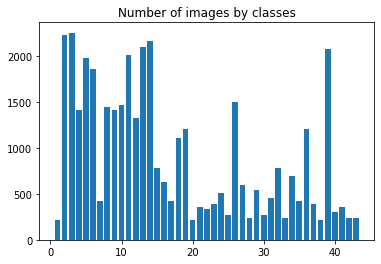

In [5]:
number_imgs_per_class = []
for i in range(N_CLASSES):
    dir_name = format(i, '05d')
    dir_path = os.path.join(GTSRB_DATA_PATH, dir_name)
    number_imgs = len(os.listdir(dir_path)) - 1
    number_imgs_per_class.append(number_imgs)
plt.bar(range(1, N_CLASSES +1), number_imgs_per_class);
plt.title("Number of images by classes")

In [6]:
print("Number of images: ", sum(number_imgs_per_class))

Number of images:  39209


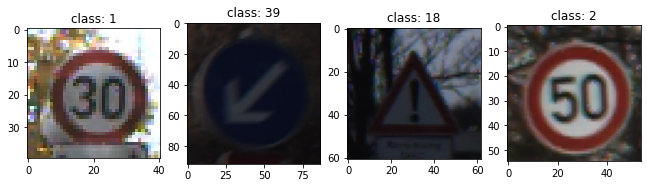

In [10]:
k = 4
all_img_paths_pattern = os.path.join(GTSRB_DATA_PATH, "**/*")
all_img_paths = glob.glob(all_img_paths_pattern)
some_img_paths = random.choices(all_img_paths, k=4)
fig = plt.gcf() 
fig.set_size_inches(11,8)
for i in range(k):
    plt.subplot(1,k,i+1)
    img = mpimg.imread(some_img_paths[i])
    class_name = some_img_paths[i].split(os.path.sep)[-2]
    plt.imshow(img)
    plt.title("class: " + str(int(class_name)))

# Make the dataset 

## Split data to train and test directory

In [11]:
def copy_files(SOURCE, DESTINATION, filenames):
    """Copy all filenames in SOURCE to DESTINATION"""
    for fname in filenames:
        source_file = os.path.join(SOURCE, fname)
        destination_file = os.path.join(DESTINATION, fname)
        shutil.copyfile(source_file, destination_file)

def train_test_split_for_one_dir(SOURCE, TRAIN, TEST, SPLIT_SIZE):
    """Creat train and test directories with their files"""
    try: 
        os.mkdir(TRAIN)
        os.mkdir(TEST)
    except OSError:
        print("Error")

    filenames = [fname for fname in os.listdir(SOURCE) if fname.endswith('.ppm')]
    train_length = int(len(filenames) * SPLIT_SIZE)    
    shuffle_filenames = random.sample(filenames, len(filenames))
    copy_files(SOURCE, TRAIN, shuffle_filenames[:train_length])
    copy_files(SOURCE, TEST, shuffle_filenames[train_length:])


def train_test_split_fulldata(SOURCE, SPLIT_SIZE):
    ROOT_PATH = os.getcwd()
    TRAIN = os.path.join(root_path, 'GTSRB_TRAIN')
    TEST = os.path.join(root_path, 'GTSRB_TEST') 
    try:
        os.mkdir(TRAIN)
        os.mkdir(TEST)
    except OSError:
        print("Error")
    for i in range(N_CLASSES):
        DIR_NAME = format(i, '05d')
        CURRENT_SOURCE = os.path.join(SOURCE, DIR_NAME)
        CURRENT_TRAIN = os.path.join(TRAIN, DIR_NAME)
        CURRENT_TEST = os.path.join(TEST, DIR_NAME)
        train_test_split_for_one_dir(CURRENT_SOURCE, CURRENT_TRAIN, CURRENT_TEST, SPLIT_SIZE)
    return TRAIN, TEST

In [12]:
random.seed(42)
TRAIN_DIR, TEST_DIR = train_test_split_fulldata(GTSRB_DATA_PATH, SPLIT_SIZE)
nb_train_imgs = len(glob.glob(TRAIN_DIR + "/**/*"))
nb_test_imgs  = len(glob.glob(TEST_DIR + "/**/*"))
print("Number of training images", nb_train_imgs)
print("Number of testing images", nb_test_imgs)

Number of training images 23525
Number of testing images 15684


## Load data

In [13]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
train_generator = training_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=RESIZED_IMAGE,
    class_mode='categorical',
    batch_size=128
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=RESIZED_IMAGE,
    class_mode='categorical',
    batch_size=32
)

Found 23525 images belonging to 43 classes.
Found 15684 images belonging to 43 classes.


# Model

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.python.keras.utils.vis_utils import plot_model

In [16]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(RESIZED_HIGHT, RESIZED_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

# Training process with history

In [18]:
EPOCHS = 25
steps_per_epoch = nb_train_imgs//128  
validation_steps = nb_test_imgs//32

history = model.fit(train_generator, 
                    epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_data = test_generator, 
                    verbose = 1, validation_steps=validation_steps)

Epoch 1/25
183/183 [==============================] - 50s 97ms/step - loss: 3.3298 - accuracy: 0.1004 - val_loss: 2.5808 - val_accuracy: 0.2297
Epoch 2/25
183/183 [==============================] - 17s 94ms/step - loss: 2.5526 - accuracy: 0.2480 - val_loss: 1.8058 - val_accuracy: 0.4273
Epoch 3/25
183/183 [==============================] - 17s 93ms/step - loss: 2.0273 - accuracy: 0.3705 - val_loss: 1.4947 - val_accuracy: 0.4878
Epoch 4/25
183/183 [==============================] - 17s 94ms/step - loss: 1.6998 - accuracy: 0.4565 - val_loss: 1.2160 - val_accuracy: 0.5832
Epoch 5/25
183/183 [==============================] - 17s 93ms/step - loss: 1.5118 - accuracy: 0.5034 - val_loss: 1.0725 - val_accuracy: 0.6318
Epoch 6/25
183/183 [==============================] - 17s 94ms/step - loss: 1.3611 - accuracy: 0.5479 - val_loss: 1.0427 - val_accuracy: 0.6348
Epoch 7/25
183/183 [==============================] - 17s 94ms/step - loss: 1.2783 - accuracy: 0.5680 - val_loss: 0.8916 - val_accuracy:

In [19]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

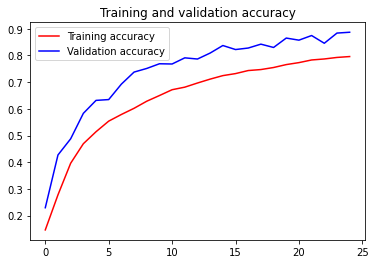

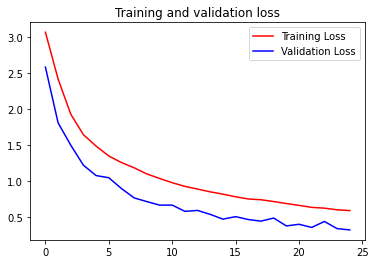

In [20]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()